# Data process

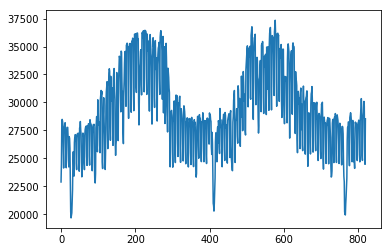

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('data.csv').set_index(['日期'])
data = df.iloc[:, 1]
plt.plot(np.arange(data.shape[0]), data, label='pred')
plt.show()

* 發現周末的電力相比一到五通常較低，在圖上會呈現一個周期性的波型
* 在過年期間的最大負載會急遽降低